In [1]:
using Revise
using RCall
using HypergraphNB
using Arpack
using MultivariateStats
using StatsBase
using DataFrames

┌ Info: Precompiling HypergraphNB [2dbe4ab3-0c84-4f8d-86d2-f64d6d698dce]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphNB does not have StatsBase in its dependencies:
│ - If you have HypergraphNB checked out for development and have
│   added StatsBase as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphNB
└ Loading StatsBase into HypergraphNB from project dependency, future warnings for HypergraphNB are suppressed.


In [2]:
function createViz(data_name, figure_path; nev = 30, nev_to_plot = 10)
    
    path      = "throughput/data-throughput/"*data_name*".csv"
    proj_path = "throughput/data-throughput/"*data_name*"-projected.csv"


    label_path = "data/"*data_name*"/label-names-"*data_name*".txt"
    
    H, z = HypergraphNB.read_hypergraph_data(data_name);
    
    
    B = reducedBPJacobian(H, z);    
    E = Arpack.eigs(B; nev = nev, ritzvec = true)            
    V = hcat([HypergraphNB.transform_eigenvector(real.(E[2][:,i]), H) for i ∈ 1:nev]...)
    
    V_ = 1.0*(V .> 0)
    M = fit(PCA, V_; maxoutdim=4)
    
    K_ = sort(collect(keys(H.E)))

    n = length(H.N)

    c, G = degreeTensor(H, z);
    q = 1/n * StatsBase.counts(z)
    G_ = zero(G)
    for i ∈ 1:length(K_)
        G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
    end
    
    DF = DataFrame()

    for i ∈ 1:length(unique(z))
        id = zeros(0)
        K = zeros(0)
        value = zeros(0)
        for k ∈ 1:size(G_, 1)
            push!(id, i)
            push!(value, G_[k,i,i])
            push!(K, K_[k])
        end
        df = DataFrame(id = id, value = value, K = K)
        DF = vcat(DF, df)
    end
        
    legend_rows = length(unique(z)) > 2 ? 2 : 1 
    
    R"""
    library(tidyverse)
    library(viridis)
    library(colorspace)
    library(patchwork)
    library(ggforce)
    
    
    df  <- read_csv($(path)) %>% mutate(projected = "Hypergraph")
    df_ <- read_csv($(proj_path)) %>% mutate(projected = "Projected graph")
    
    
    df <- df %>% 
        rbind(df_) %>% 
        mutate(obj = cost_SS / tot_SS) 
    
    best_df <- df %>% 
        filter(nev == $(nev_to_plot)) %>% 
        group_by(projected) %>% 
        filter(obj == min(obj, na.rm = T)) %>% 
        filter(row_number() == 1)
    
    p <- df %>% 
        filter(nev == $(nev_to_plot)) %>% 
        group_by(ngroups, projected) %>% 
        filter(obj == min(obj, na.rm = T)) %>% 
        filter(row_number() == 1) %>% 
        ggplot() + 
        geom_vline(aes(xintercept = factor($(length(unique(z))))), color = "grey") + 
        aes(x = factor(ngroups), y = ari, group = projected) +
        geom_line(aes(linetype = projected), color = "darkslategray") +     
        geom_point(color = "darkslategray", pch = 21, fill = "white") + 
#        geom_point(color = "darkslategray", pch = 21, fill = "black", data = best_df) + 
        theme_bw() + 
        theme(strip.background = element_blank(),
              legend.position = "bottom",
              panel.border = element_rect(color = NA)) + 
        scale_color_brewer(palette = "Set2") +
        guides(color = guide_legend(title = element_blank()),
               linetype = guide_legend(title = element_blank())) + 
        xlab("Number of estimated groups") + 
        ylab("Adjusted Rand Index against ground truth") +
        scale_y_continuous(limits = c(NA, 1)) + 
        ggtitle(paste("Cluster recovery with", $(nev_to_plot), "eigenvectors")) 
    

    df <- tibble(z = $z, m1 = $(M.proj[:,1]), m2 = $(M.proj[:,2])) 

    labels <- read_csv($(label_path), col_names = c("name")) %>% 
        mutate(id = row_number())

    
    q <- df %>% 
        left_join(labels, by = c("z" = "id")) %>%  
        ggplot() + 
        aes(x = m1, y = m2, color = name) + 
        ggforce::geom_mark_hull(aes(fill = name), alpha = 0.2) + 
        geom_point(pch = 21) + 
        theme_bw() +
        xlab("1st principal component") + 
        ylab("2nd principal component") + 
        guides(color = guide_legend(title = element_blank(), nrow = $legend_rows),
               fill = FALSE) + 
        scale_color_discrete_qualitative(palette = "dynamic") + 
        theme(panel.border = element_rect(color = NA),
              legend.position = "bottom") + 
        ggtitle("Eigenspace visualization (via PCA)")
    
    
    r <- $(DF) %>% 
        left_join(labels, by = c("id" = "id")) %>% 
        ggplot() + 
        aes(x = K, y = value, color = name, group = name) + 
        geom_line() + 
        geom_point(pch = 21, fill = "white") + 
        theme_bw() + 
        scale_color_discrete_qualitative(palette = "dynamic") + 
        guides(color = guide_legend(title = element_blank(), nrow = $legend_rows)) + 
        theme(panel.border = element_rect(color = NA),
              legend.position = "bottom") + 
        xlab(expression(paste("Edge size ", italic(k)))) + 
        ylab(expression(paste("Affinity ", italic(c)))) + 
        ggtitle("Within-group affinities")

    p + q + r
    
    ggsave($(figure_path), width = 12, height = 4, dpi = 300)
            
    """
end

createViz (generic function with 1 method)

In [3]:
data_name = "SN-congress-bills"
createViz(data_name, "fig/"*data_name*".png", nev_to_plot = 10)

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: viridisLite
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_do

RObject{NilSxp}
NULL


In [4]:
data_name = "contact-high-school-classes"
createViz(data_name, "fig/"*data_name*".png", nev_to_plot = 30)

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   name = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: The concaveman package is required for geom_mark_hull
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


In [5]:
data_name = "contact-primary-school-classes"
createViz(data_name, "fig/"*data_name*".png", nev_to_plot = 30)

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   name = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: The concaveman package is required for geom_mark_hull
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'projected', 'ngroups' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


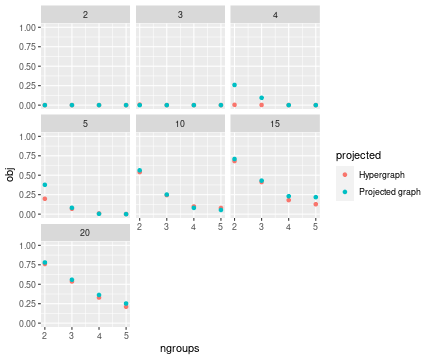

RObject{VecSxp}


In [6]:
data_name = "SN-congress-bills"

path      = "throughput/data-throughput/"*data_name*".csv"
proj_path = "throughput/data-throughput/"*data_name*"-projected.csv"
R"""
df  <- read_csv($(path)) %>% mutate(projected = "Hypergraph")
df_ <- read_csv($(proj_path)) %>% mutate(projected = "Projected graph")
    
    
df <- df %>% 
    rbind(df_) %>% 
    mutate(obj = cost_SS / tot_SS) %>% 
    group_by(projected, ngroups, nev) %>% 
    filter(obj == min(obj, na.rm = T))



df %>% 
    group_by(projected, ngroups, nev) %>% 
    summarise(obj = mean(obj, na.rm = T)) %>% 
    ggplot() + 
    aes(x = ngroups, y = obj, color = projected) + 
    geom_point() + 
    facet_wrap(~nev) + 
    ylim(c(0, 1))

"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


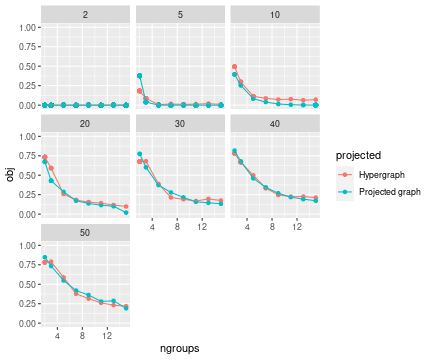

RObject{VecSxp}


In [7]:
data_name = "contact-high-school-classes"

path      = "throughput/data-throughput/"*data_name*".csv"
proj_path = "throughput/data-throughput/"*data_name*"-projected.csv"
R"""
df  <- read_csv($(path)) %>% mutate(projected = "Hypergraph")
df_ <- read_csv($(proj_path)) %>% mutate(projected = "Projected graph")
    
    
df <- df %>% 
    rbind(df_) %>% 
    mutate(obj = cost_SS / tot_SS) %>% 
    group_by(projected, ngroups, nev) %>% 
    filter(obj == min(obj, na.rm = T))



df %>% 
    ggplot() + 
    aes(x = ngroups, y = obj, color = projected) + 
    geom_point() + 
    geom_line() + 
    facet_wrap(~nev) + 
    ylim(c(NA, 1))

"""

In [30]:
function createViz2(data_name, figure_path; nev = 30, nev_to_plot = 10)
    
    path      = "throughput/data-throughput/"*data_name*".csv"
    proj_path = "throughput/data-throughput/"*data_name*"-projected.csv"


    label_path = "data/"*data_name*"/label-names-"*data_name*".txt"
    
    H, z = HypergraphNB.read_hypergraph_data(data_name);
    
    n = length(H.N)
    K_ = sort(collect(keys(H.E)))
    
    c, G = degreeTensor(H, z);
    q = 1/n * StatsBase.counts(z)
    G_ = zero(G)
    for i ∈ 1:length(K_)
        G_[i,:,:] = (G[i,:,:] / ((K_[i] - 1) * c[i]) .- 1) .* q
    end
    
    DF = DataFrame()

    for i ∈ 1:length(unique(z))
        id = zeros(0)
        K = zeros(0)
        value = zeros(0)
        for k ∈ 1:size(G_, 1)
            push!(id, i)
            push!(value, G_[k,i,i])
            push!(K, K_[k])
        end
        df = DataFrame(id = id, value = value, K = K)
        DF = vcat(DF, df)
    end
        
    legend_rows = length(unique(z)) > 2 ? 2 : 1 
    
    R"""
    library(tidyverse)
    library(viridis)
    library(colorspace)
    library(patchwork)
    library(ggforce)
    
    
    df  <- read_csv($(path)) %>% mutate(projected = "Hypergraph")
    df_ <- read_csv($(proj_path)) %>% mutate(projected = "Projected graph")
    
    
    df <- df %>% 
        rbind(df_) %>% 
        mutate(obj = cost_SS / tot_SS) 
    
    best_df <- df %>% 
        filter(nev == $(nev_to_plot)) %>% 
        group_by(projected) %>% 
        filter(obj == min(obj, na.rm = T)) %>% 
        filter(row_number() == 1)
    
    q <- df %>% 
        filter(nev == $(nev_to_plot)) %>% 
        group_by(ngroups, projected) %>% 
        filter(obj == min(obj, na.rm = T)) %>% 
        filter(row_number() == 1) %>% 
        ggplot() + 
        geom_vline(aes(xintercept = factor($(length(unique(z))))), color = "grey") + 
        aes(x = factor(ngroups), y = obj, group = projected) +
        geom_line(aes(linetype = projected), color = "firebrick") +     
        geom_point(color = "firebrick", pch = 21, fill = "white") + 
#        geom_point(color = "darkslategray", pch = 21, fill = "black", data = best_df) + 
        theme_bw() + 
        theme(strip.background = element_blank(),
              legend.position = "bottom",
              panel.border = element_rect(color = NA), 
              legend.text = element_text(size = 11)) + 
        scale_color_brewer(palette = "Set2") +
        guides(color = guide_legend(title = element_blank()),
               linetype = guide_legend(title = element_blank())) + 
        xlab("Number of groups ℓ") + 
        ylab("Proportion of within-group variance") +
        scale_y_continuous(limits = c(NA, 1)) + 
        ggtitle(paste("Scree plot with", $(nev_to_plot), "eigenvectors")) 
    
    
    
    
    p <- df %>% 
        filter(nev == $(nev_to_plot)) %>% 
        group_by(ngroups, projected) %>% 
        filter(obj == min(obj, na.rm = T)) %>% 
        filter(row_number() == 1) %>% 
        ggplot() + 
        geom_vline(aes(xintercept = factor($(length(unique(z))))), color = "grey") + 
        aes(x = factor(ngroups), y = ari, group = projected) +
        geom_line(aes(linetype = projected), color = "darkslategray") +     
        geom_point(color = "darkslategray", pch = 21, fill = "white") + 
#        geom_point(color = "darkslategray", pch = 21, fill = "black", data = best_df) + 
        theme_bw() + 
        theme(strip.background = element_blank(),
              legend.position = "bottom",
              panel.border = element_rect(color = NA), 
              legend.text = element_text(size = 11)) + 
        scale_color_brewer(palette = "Set2") +
        guides(color = guide_legend(title = element_blank()),
               linetype = guide_legend(title = element_blank())) + 
        xlab(expression("Number of groups ℓ")) + 
        ylab("Adjusted Rand Index against ground truth") +
        scale_y_continuous(limits = c(NA, 1)) + 
        ggtitle(paste("Cluster recovery with", $(nev_to_plot), "eigenvectors")) 
    
    labels <- read_csv($(label_path), col_names = c("name")) %>% 
        mutate(id = row_number())
    
    r <- $(DF) %>% 
        left_join(labels, by = c("id" = "id")) %>% 
        ggplot() + 
        aes(x = K, y = value, color = name, group = name) + 
        geom_line() + 
        geom_point(pch = 21, fill = "white") + 
        theme_bw() + 
        scale_color_discrete_qualitative(palette = "dynamic") + 
        guides(color = guide_legend(title = element_blank(), nrow = $legend_rows)) + 
        theme(panel.border = element_rect(color = NA),
              legend.position = "bottom", 
              legend.text = element_text(size = 9)) + 
        xlab(expression(paste("Edge size ", italic(k)))) + 
        ylab(expression(paste("Affinity ", italic(c)))) + 
        ggtitle("Within-group affinities")

    (q + p + plot_layout(guides = "auto")) + r 
    
    ggsave($(figure_path), width = 12, height = 4, dpi = 300)
            
    """
end

createViz2 (generic function with 1 method)

In [31]:
data_name = "contact-primary-school-classes"
createViz2(data_name, "fig/"*data_name*"2.png", nev_to_plot = 30)

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   name = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


In [32]:
data_name = "contact-high-school-classes"
createViz2(data_name, "fig/"*data_name*"2.png", nev_to_plot = 30)

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   name = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL


In [33]:
data_name = "SN-congress-bills"
createViz2(data_name, "fig/"*data_name*"2.png", nev_to_plot = 20)

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   ngroups = col_double(),
│   nev = col_double(),
│   tot_SS = col_double(),
│   cost_SS = col_double(),
│   ari = col_double(),
│   round = col_double(),
│   data = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   name = col_character()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL
